In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker as mtick
from matplotlib.ticker import FuncFormatter
plt.style.use('ggplot')
import seaborn as sns
pd.options.display.float_format = '{:,.0f}'.format
from IPython.display import display
import dataframe_image as dfi
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
encoder = OneHotEncoder(sparse_output=False)
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn import ensemble
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
import shap
import warnings
import random
warnings.filterwarnings('ignore')
import ipywidgets as widgets
#widgets.IntSlider()

In [2]:
#Import Imputeed Ames Data
Ames = pd.read_csv('Ames_HousePrice_Imputed.csv')

#Update with new Ames Data
Ames_Columns_Numeric = Ames[[
    '1stFlrSF', '2ndFlrSF', '3SsnPorch', 'BedroomAbvGr', 'BsmtFinSF1', 'BsmtFinSF2',
    'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF', 'EnclosedPorch', 'Fireplaces', 'FullBath',
    'GarageArea', 'GarageCars', 'GarageYrBlt', 'GrLivArea', 'HalfBath', 'KitchenAbvGr',
    'LotArea', 'LotFrontage', 'LowQualFinSF', 'MasVnrArea', 'MiscVal', 'MoSold',
    'OpenPorchSF', 'PoolArea', 'ScreenPorch', 'TotalBsmtSF', 'TotRmsAbvGrd', 'WoodDeckSF',
    'YearBuilt', 'YearRemodAdd', 'YrSold'
]].apply(pd.to_numeric, errors='coerce')

Ames_Columns_Ordinal = Ames[[
    'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual',
    'Electrical', 'ExterCond', 'ExterQual', 'Fence', 'FireplaceQu', 'Functional',
    'GarageCond', 'GarageFinish', 'GarageQual', 'HeatingQC', 'KitchenQual',
    'LandSlope', 'LotShape', 'OverallCond', 'OverallQual', 'PavedDrive',
    'PoolQC', 'Utilities'
]].apply(pd.to_numeric, errors='coerce')

Ames_Columns_Nominal = Ames[[ 
    'Alley', 'BldgType', 'CentralAir', 'Condition1', 'Condition2',
    'Exterior1st', 'Exterior2nd', 'Foundation', 'GarageType', 'Heating',
    'HouseStyle', 'LandContour', 'LotConfig', 'MasVnrType', 'MiscFeature',
    'MSSubClass', 'MSZoning', 'Neighborhood', 'RoofMatl', 'RoofStyle',
    'SaleCondition', 'SaleType', 'Street'
]].astype('category')

#Combination Table of Numeric & Ordinal Columns
Ames_Columns_Numeric_Ordinal = Ames[
    list(Ames_Columns_Numeric.columns) + list(Ames_Columns_Ordinal.columns)
]
#Combination Table of Nominal & Ordinal Columns
Ames_Columns_Nominal_Ordinal = Ames[
    list(Ames_Columns_Nominal.columns) + list(Ames_Columns_Ordinal.columns)
]

In [3]:
'''
encoder = OneHotEncoder(sparse_output=False)
encoder_nominal = OneHotEncoder(sparse_output=False)
encoder_ordinal = OneHotEncoder(sparse_output=False)
Nominal_cols = Ames_Columns_Nominal.columns
Ordinal_cols = Ames_Columns_Ordinal.columns
Numeric_cols = Ames_Columns_Numeric.columns

#One-Hot Encode Nominal
Ames_Optimal_Nominal_One_Hot = encoder_nominal.fit_transform(Ames[Nominal_cols])
Ames_Optimal_Nominal_One_Hot_df = pd.DataFrame(
    Ames_Optimal_Nominal_One_Hot,
    columns=encoder_nominal.get_feature_names_out(Nominal_cols),
    index=Ames.index
)
#DO NOT One-Hot Encode Ordinal (for now)
Ames_Optimal_Ordinal_One_Hot = Ames_Columns_Ordinal #encoder_ordinal.fit_transform(Ames[Ordinal_cols])
Ames_Optimal_Ordinal_One_Hot_df = pd.DataFrame(
    Ames_Optimal_Ordinal_One_Hot,
    #columns=encoder_ordinal.get_feature_names_out(Ordinal_cols),
    index=Ames.index
)
#Merge Nominal & Ordinal Encodings
Ames_Optimal_Categorical_One_Hot = pd.merge(
    Ames_Optimal_Nominal_One_Hot_df,
    Ames_Optimal_Ordinal_One_Hot_df,
    left_index=True,
    right_index=True,
    how='left'
)
#Merge with Numeric Features
Ames_MLR_Optimal_Columns = pd.merge(
    Ames[Numeric_cols],
    Ames_Optimal_Categorical_One_Hot,
    left_index=True,
    right_index=True,
    how='left'
)
X = Ames_MLR_Optimal_Columns
'''

"\nencoder = OneHotEncoder(sparse_output=False)\nencoder_nominal = OneHotEncoder(sparse_output=False)\nencoder_ordinal = OneHotEncoder(sparse_output=False)\nNominal_cols = Ames_Columns_Nominal.columns\nOrdinal_cols = Ames_Columns_Ordinal.columns\nNumeric_cols = Ames_Columns_Numeric.columns\n\n#One-Hot Encode Nominal\nAmes_Optimal_Nominal_One_Hot = encoder_nominal.fit_transform(Ames[Nominal_cols])\nAmes_Optimal_Nominal_One_Hot_df = pd.DataFrame(\n    Ames_Optimal_Nominal_One_Hot,\n    columns=encoder_nominal.get_feature_names_out(Nominal_cols),\n    index=Ames.index\n)\n#DO NOT One-Hot Encode Ordinal (for now)\nAmes_Optimal_Ordinal_One_Hot = Ames_Columns_Ordinal #encoder_ordinal.fit_transform(Ames[Ordinal_cols])\nAmes_Optimal_Ordinal_One_Hot_df = pd.DataFrame(\n    Ames_Optimal_Ordinal_One_Hot,\n    #columns=encoder_ordinal.get_feature_names_out(Ordinal_cols),\n    index=Ames.index\n)\n#Merge Nominal & Ordinal Encodings\nAmes_Optimal_Categorical_One_Hot = pd.merge(\n    Ames_Optimal_Nom

In [4]:
Y = Ames['SalePrice']

#Alternate Version with no One Hot Encoding for HistGradient, LightGBM, and CatBoost
X2 = pd.concat([Ames_Columns_Numeric, Ames_Columns_Ordinal, Ames_Columns_Nominal], axis=1)
for col in Ames_Columns_Nominal.columns:
    X2[col] = X2[col].astype('category')
    Ames[col] = Ames[col].astype('category')

In [5]:
def Plot_HGB_Feature_Importances(model, X=X2, Y=Y, top_n=10, n_permutations=10):
    pd.options.display.float_format = None
    best_model = model.best_estimator_ if hasattr(model, 'best_estimator_') else model
    model_name = type(best_model).__name__

    #Permutation (Feature) Importances
    print(f'Calculating permutation importances for {model_name}...')
    perm_imp = permutation_importance(best_model, X, Y,
                                      n_repeats=n_permutations,
                                      random_state=2, n_jobs=-1)
    feature_importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': perm_imp.importances_mean
    }).sort_values('Importance', ascending=False)

    #Plot Top Features
    top_features = feature_importance_df.head(top_n)
    y_pos = np.arange(len(top_features))
    palette = sns.color_palette('rocket', len(top_features))
    plt.figure(figsize=(10, top_n * 0.4), dpi=300)
    ax = sns.barplot(x=top_features['Importance'], y=top_features['Feature'], data=top_features, palette=palette)
    plt.title(f'{model_name} - Top {top_n} Feature Importances', fontsize=20, fontweight='bold')
    plt.xlabel('Permutation Importance', fontsize=15)
    plt.ylabel('Features', fontsize=15)
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.4f}'))
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

    #Display Data Frame Top Features
    display(feature_importance_df.head(top_n).style.format({'Importance': '{:.4f}'}))

In [6]:
def Plot_Feature_Importances_Only(model, X, top_n=10, max_estimators=20):
    best_model = model.best_estimator_ if hasattr(model, 'best_estimator_') else model
    model_name = type(best_model).__name__
    importances = None

    #Bagged models
    if hasattr(best_model, 'estimators_') and hasattr(best_model.estimators_[0], 'feature_importances_'):
        selected_estimators = best_model.estimators_
        if max_estimators < len(selected_estimators):
            selected_estimators = random.sample(selected_estimators, k=max_estimators)
        importances = np.mean([est.feature_importances_ for est in selected_estimators], axis=0)

    #Boosting models
    elif hasattr(best_model, 'feature_importances_'):
        importances = best_model.feature_importances_

    # CatBoost
    elif 'cat' in model_name.lower() and hasattr(best_model, 'get_feature_importance'):
        importances = best_model.get_feature_importance()

    #If error
    if importances is None:
        print(f"{model_name} does not expose feature importances")
        feature_df = pd.DataFrame({'Feature': X.columns, 'Importance': np.nan})
    else:
        importances = np.array(importances, dtype=float)
        total = np.sum(importances)
        if total != 0 and not np.isnan(total):
            importances /= total  #NORMALIZE to 1
        feature_df = pd.DataFrame({'Feature': X.columns, 'Importance': np.round(importances, 4)})

    #Plot Feature Importances
    feature_df = feature_df.sort_values('Importance', ascending=False).reset_index(drop=True)
    top_features = feature_df.head(top_n).copy()
    y_pos = np.arange(len(top_features))
    
    palette = sns.color_palette('rocket', len(top_features))
    plt.figure(figsize=(10, top_n * 0.4), dpi=300)
    ax = sns.barplot(x=top_features['Importance'], y=top_features['Feature'], data=top_features, palette=palette)
    plt.title(f'{model_name} - Top {top_n} Feature Importances', fontsize=20, fontweight='bold')
    plt.xlabel('Permutation Importance', fontsize=15)
    plt.ylabel('Features', fontsize=15)
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.4f}'))
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

    #Display Table
    display(feature_df.head(top_n).style.format({'Importance': '{:.4f}'}))

In [7]:
#Hist Gradient Boosting Base Model
hgbm = HistGradientBoostingRegressor(random_state=2, verbose=1,
    categorical_features=[
        X2.columns.get_loc(col) for col in Ames_Columns_Nominal.columns]
)
hgbm.fit(X2, Y)
hgbm_cv_scores = cross_val_score(hgbm, X2, Y, cv=5, scoring='r2')
hgbm_mean_cv_score = np.mean(hgbm_cv_scores)

hgbm_base_results_df = pd.DataFrame({
    'Model_Category': ['Tree_Based'],
    'Model_Scaling': ['None'],
	'OneHot': ['Native'],
    'Tuning': ['Base'],
    'Model': ['HistGradientBoosting'],
    'Mean_R²': [hgbm_mean_cv_score],
    **{f'Fold_{i+1}_R²': [hgbm_cv_scores[i]] for i in range(5)}
})

Binning 0.002 GB of training data: 0.031 s
Fitting gradient boosted rounds:
Fit 100 trees in 2.350 s, (3100 total leaves)
Time spent computing histograms: 0.108s
Time spent finding best splits:  0.055s
Time spent applying splits:      0.053s
Time spent predicting:           0.003s
Binning 0.001 GB of training data: 0.033 s
Fitting gradient boosted rounds:
Fit 100 trees in 0.294 s, (3100 total leaves)
Time spent computing histograms: 0.083s
Time spent finding best splits:  0.047s
Time spent applying splits:      0.045s
Time spent predicting:           0.002s
Binning 0.001 GB of training data: 0.032 s
Fitting gradient boosted rounds:
Fit 100 trees in 0.304 s, (3100 total leaves)
Time spent computing histograms: 0.092s
Time spent finding best splits:  0.046s
Time spent applying splits:      0.045s
Time spent predicting:           0.003s
Binning 0.001 GB of training data: 0.034 s
Fitting gradient boosted rounds:
Fit 100 trees in 0.277 s, (3100 total leaves)
Time spent computing histograms:

In [9]:
print('HistGradientBoosting Base Model Score:', float(cross_val_score(hgbm, X2, Y).mean()))

Binning 0.001 GB of training data: 0.019 s
Fitting gradient boosted rounds:
Fit 100 trees in 0.309 s, (3100 total leaves)
Time spent computing histograms: 0.093s
Time spent finding best splits:  0.054s
Time spent applying splits:      0.053s
Time spent predicting:           0.003s
Binning 0.001 GB of training data: 0.032 s
Fitting gradient boosted rounds:
Fit 100 trees in 0.290 s, (3100 total leaves)
Time spent computing histograms: 0.084s
Time spent finding best splits:  0.049s
Time spent applying splits:      0.045s
Time spent predicting:           0.002s
Binning 0.001 GB of training data: 0.034 s
Fitting gradient boosted rounds:
Fit 100 trees in 0.291 s, (3100 total leaves)
Time spent computing histograms: 0.076s
Time spent finding best splits:  0.049s
Time spent applying splits:      0.048s
Time spent predicting:           0.003s
Binning 0.001 GB of training data: 0.034 s
Fitting gradient boosted rounds:
Fit 100 trees in 0.297 s, (3100 total leaves)
Time spent computing histograms:

In [9]:
#Initial Hist Gradient Boosting RandomizedSearchCV for faster estimates
hgbm_param = {
    'learning_rate': [0.06425],
    'max_leaf_nodes': [10],
    'max_iter': [224],
    'min_samples_leaf': [15],
    'l2_regularization': np.linspace(.05, .3, 10),
}
random_search_hgb = RandomizedSearchCV(
    estimator=hgbm,
    param_distributions=hgbm_param,
    n_iter=20,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    random_state=2,
    verbose=1
)
random_search_hgb.fit(X2, Y)
print('Best parameters:', random_search_hgb.best_params_)
print(f'Best CV Score: {random_search_hgb.best_score_:.4f}')

#Results Dataframe
hgbm_cv_results_df = pd.DataFrame(random_search_hgb.cv_results_)
hgbm_best_row = hgbm_cv_results_df.loc[hgbm_cv_results_df['rank_test_score'] == 1].iloc[0]
hgbm_fold_scores = [hgbm_best_row[f'split{i}_test_score'] for i in range(5)]
hgbm_tuned_results_df = pd.DataFrame({
    'Model_Category': ['Tree_Based'],
    'Model_Scaling': ['None'],
    'OneHot': ['Native'],
    'Tuning': ['Tuned'],
    'Model': ['HistGradientBoosting'],
    'Mean_R²': [hgbm_best_row['mean_test_score']],
    **{f'Fold_{i+1}_R²': [hgbm_fold_scores[i]] for i in range(5)}
})

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Binning 0.002 GB of training data: 0.020 s
Fitting gradient boosted rounds:
Fit 224 trees in 0.222 s, (2240 total leaves)
Time spent computing histograms: 0.054s
Time spent finding best splits:  0.047s
Time spent applying splits:      0.031s
Time spent predicting:           0.004s
Best parameters: {'min_samples_leaf': 15, 'max_leaf_nodes': 10, 'max_iter': 224, 'learning_rate': 0.06425, 'l2_regularization': np.float64(0.10555555555555556)}
Best CV Score: 0.9258


Calculating permutation importances for HistGradientBoostingRegressor...


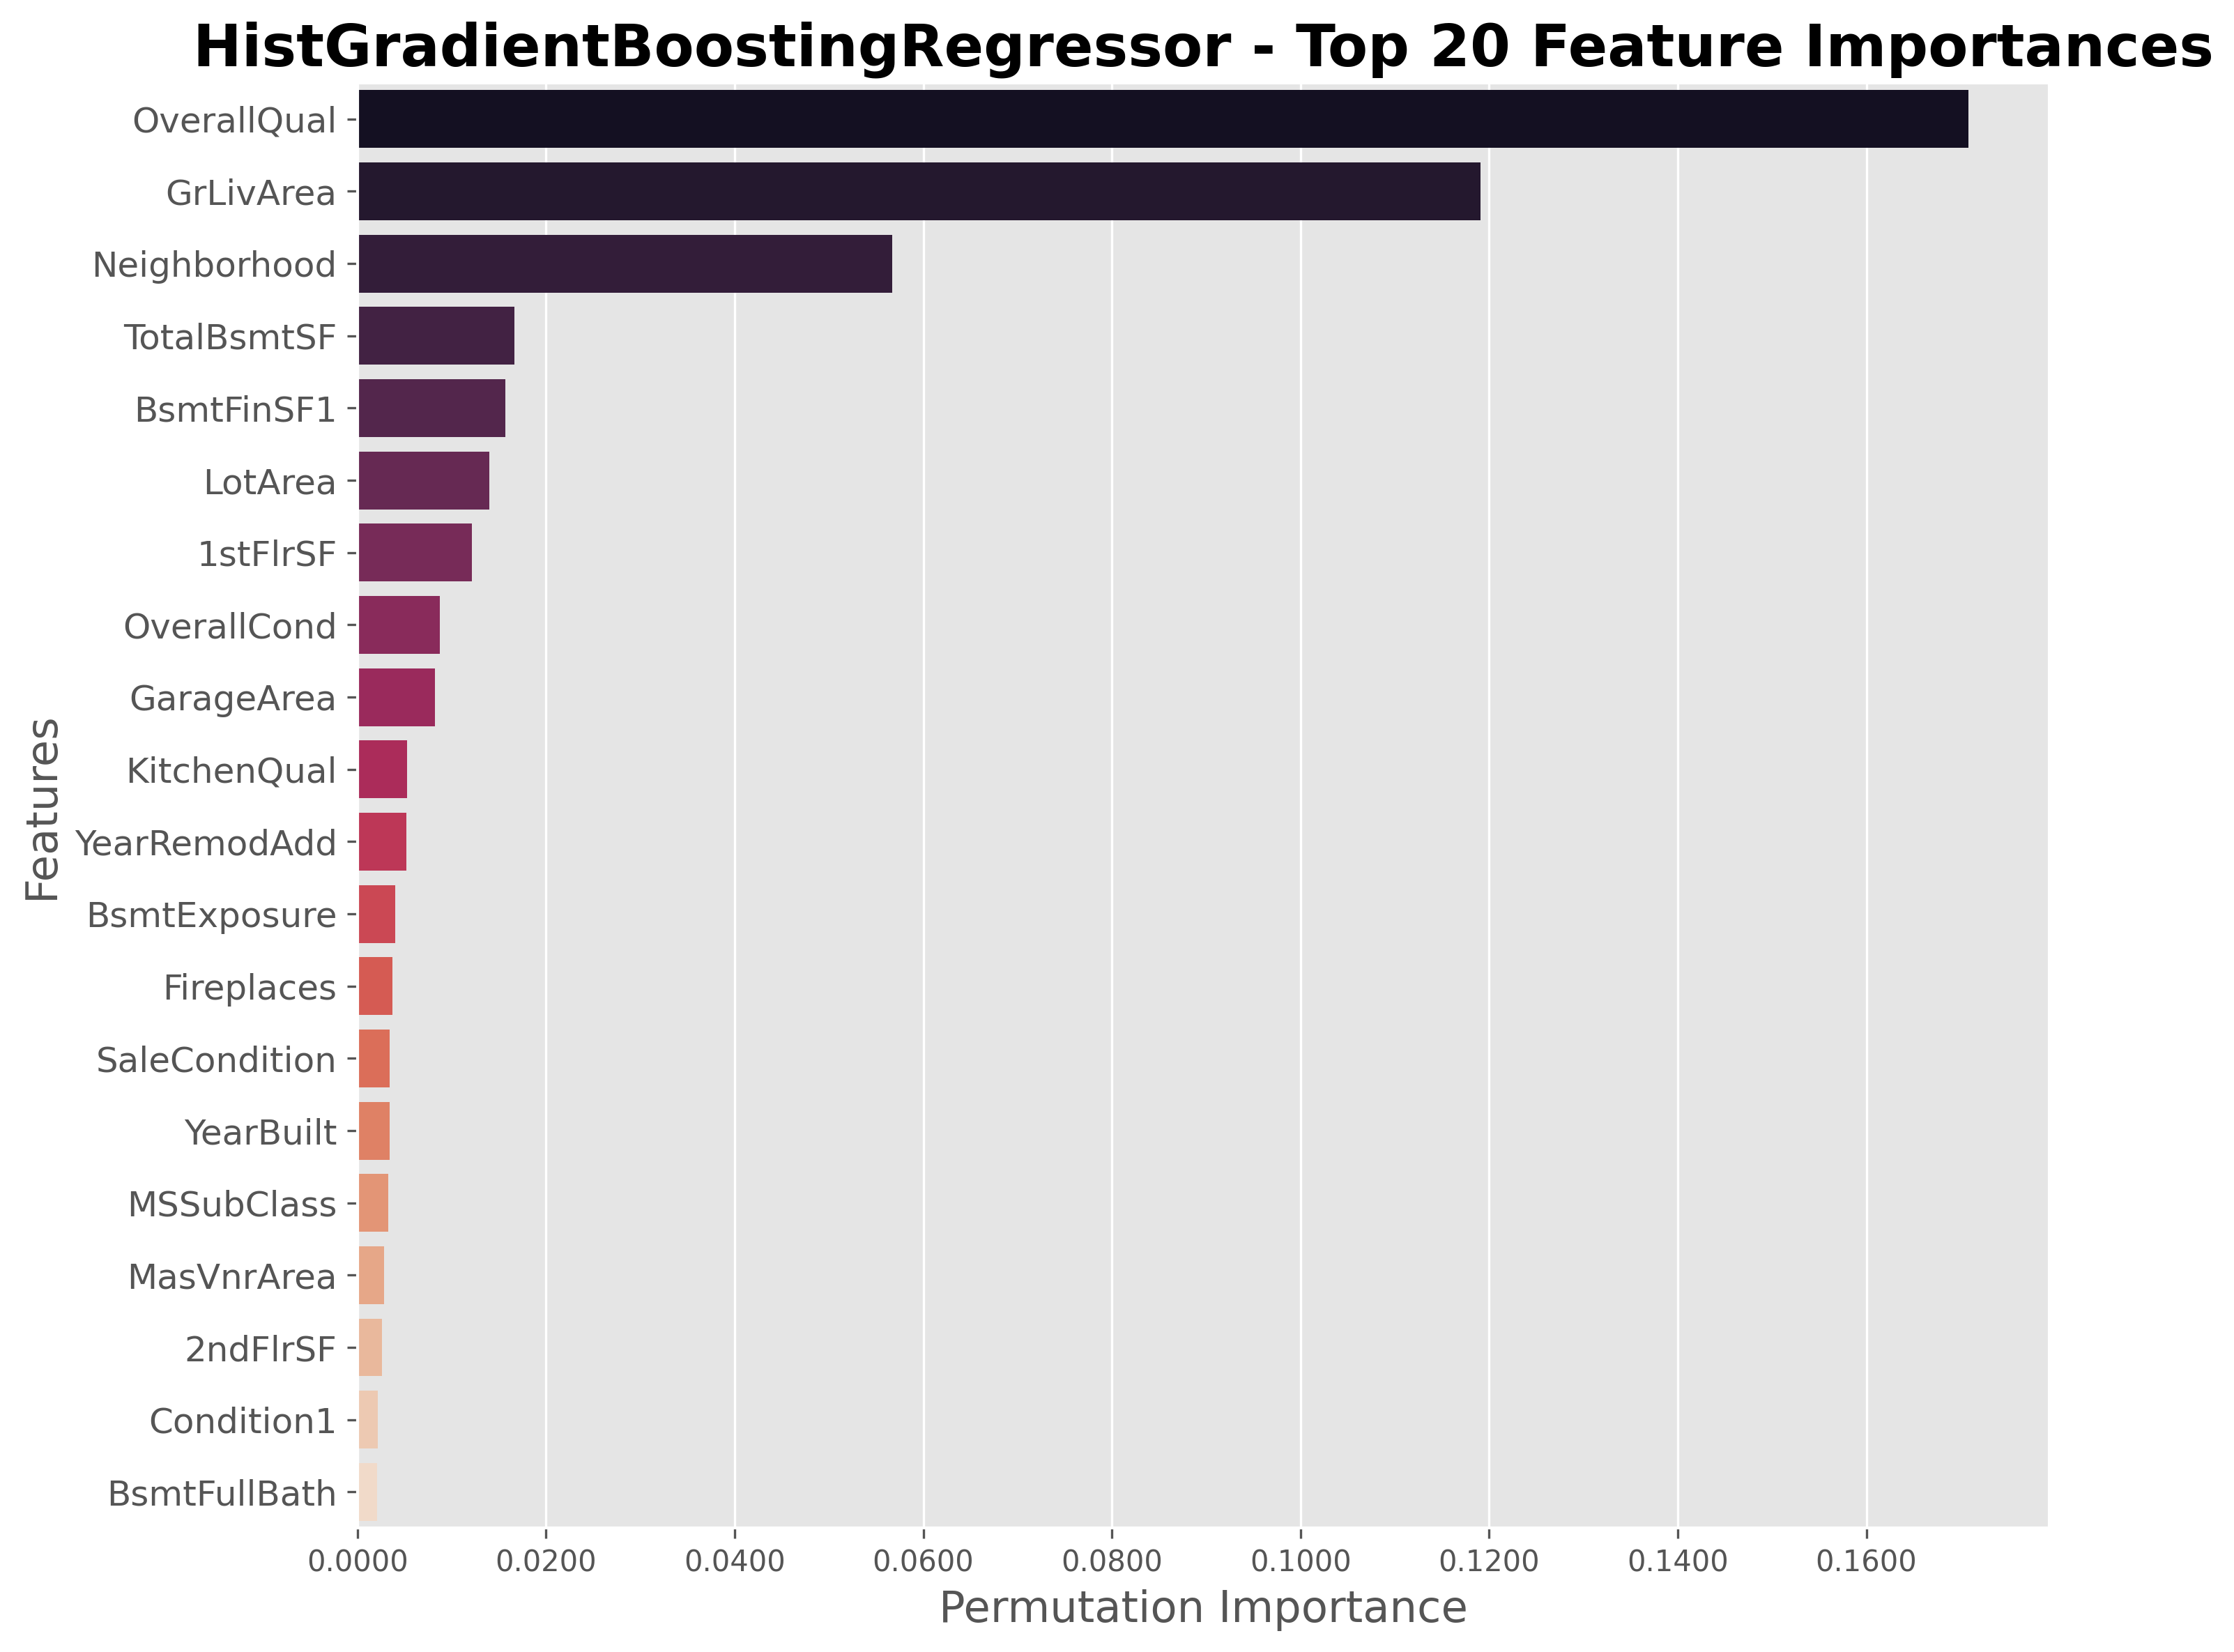

,Feature,Importance
52,OverallQual,0.1709
15,GrLivArea,0.1191
73,Neighborhood,0.0567
27,TotalBsmtSF,0.0166
4,BsmtFinSF1,0.0156
18,LotArea,0.0140
0,1stFlrSF,0.0121
51,OverallCond,0.0088
12,GarageArea,0.0082
48,KitchenQual,0.0053


In [21]:
#Hist Gradient Boosting Regressor Feature Importances & SHAP values
Plot_HGB_Feature_Importances(random_search_hgb, X2)

In [11]:
#Base XGBoost Model
xgbm = XGBRegressor(random_state=2, enable_categorical=True, n_jobs=-1, verbosity=1, booster='gbtree')
xgbm.fit(X2, Y)
#Results Dataframe
xgbm_cv_scores = cross_val_score(xgbm, X2, Y, cv=5, scoring='r2')
xgbm_mean_cv_score = np.mean(xgbm_cv_scores)
xgbm_base_results_df = pd.DataFrame({
    'Model_Category': ['Tree_Based'],
    'Model_Scaling': ['None'],
	'OneHot': ['Native'],
    'Tuning': ['Base'],
    'Model': ['XGBoost'],
    'Mean_R²': [xgbm_mean_cv_score],
    **{f'Fold_{i+1}_R²': [xgbm_cv_scores[i]] for i in range(5)}
})

In [56]:
print('XGBoost Base Model Score:', float(cross_val_score(xgbm, X2, Y).mean()))

XGBoost Base Model Score: 0.9031043767929077


In [21]:
#Initial XGBoost RandomizedSearchCV for faster estimates
xgbm_param = {
    'learning_rate': [0.046000000000000006],
    'subsample': [.35],
    'colsample_bytree': [.875],
    'max_depth': range(3, 5),
    'n_estimators': [245],
    'min_child_weight': [3],
    'gamma': np.linspace(.175, .35, 6),
    'reg_lambda': [.5],
    'reg_alpha': [.75],
}
random_search_xgbm = RandomizedSearchCV(
    estimator=xgbm,
    param_distributions=xgbm_param,
    n_iter=20,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    random_state=2,
    verbose=1
)
random_search_xgbm.fit(X2, Y)
print('Best parameters:', random_search_xgbm.best_params_)
print(f'Best CV Score: {random_search_xgbm.best_score_:.4f}')

#Results Dataframe
xgbm_cv_results_df = pd.DataFrame(random_search_xgbm.cv_results_)
xgbm_best_row = xgbm_cv_results_df.loc[xgbm_cv_results_df['rank_test_score'] == 1].iloc[0]
xgbm_fold_scores = [xgbm_best_row[f'split{i}_test_score'] for i in range(5)]
xgbm_tuned_results_df = pd.DataFrame({
    'Model_Category': ['Tree_Based'],
    'Model_Scaling': ['None'],
    'OneHot': ['Native'],
    'Tuning': ['Tuned'],
    'Model': ['XGBoost'],
    'Mean_R²': [xgbm_best_row['mean_test_score']],
    **{f'Fold_{i+1}_R²': [xgbm_fold_scores[i]] for i in range(5)}
})

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters: {'subsample': 0.35, 'reg_lambda': 0.5, 'reg_alpha': 0.75, 'n_estimators': 245, 'min_child_weight': 3, 'max_depth': 4, 'learning_rate': 0.046000000000000006, 'gamma': np.float64(0.175), 'colsample_bytree': 0.875}
Best CV Score: 0.9260


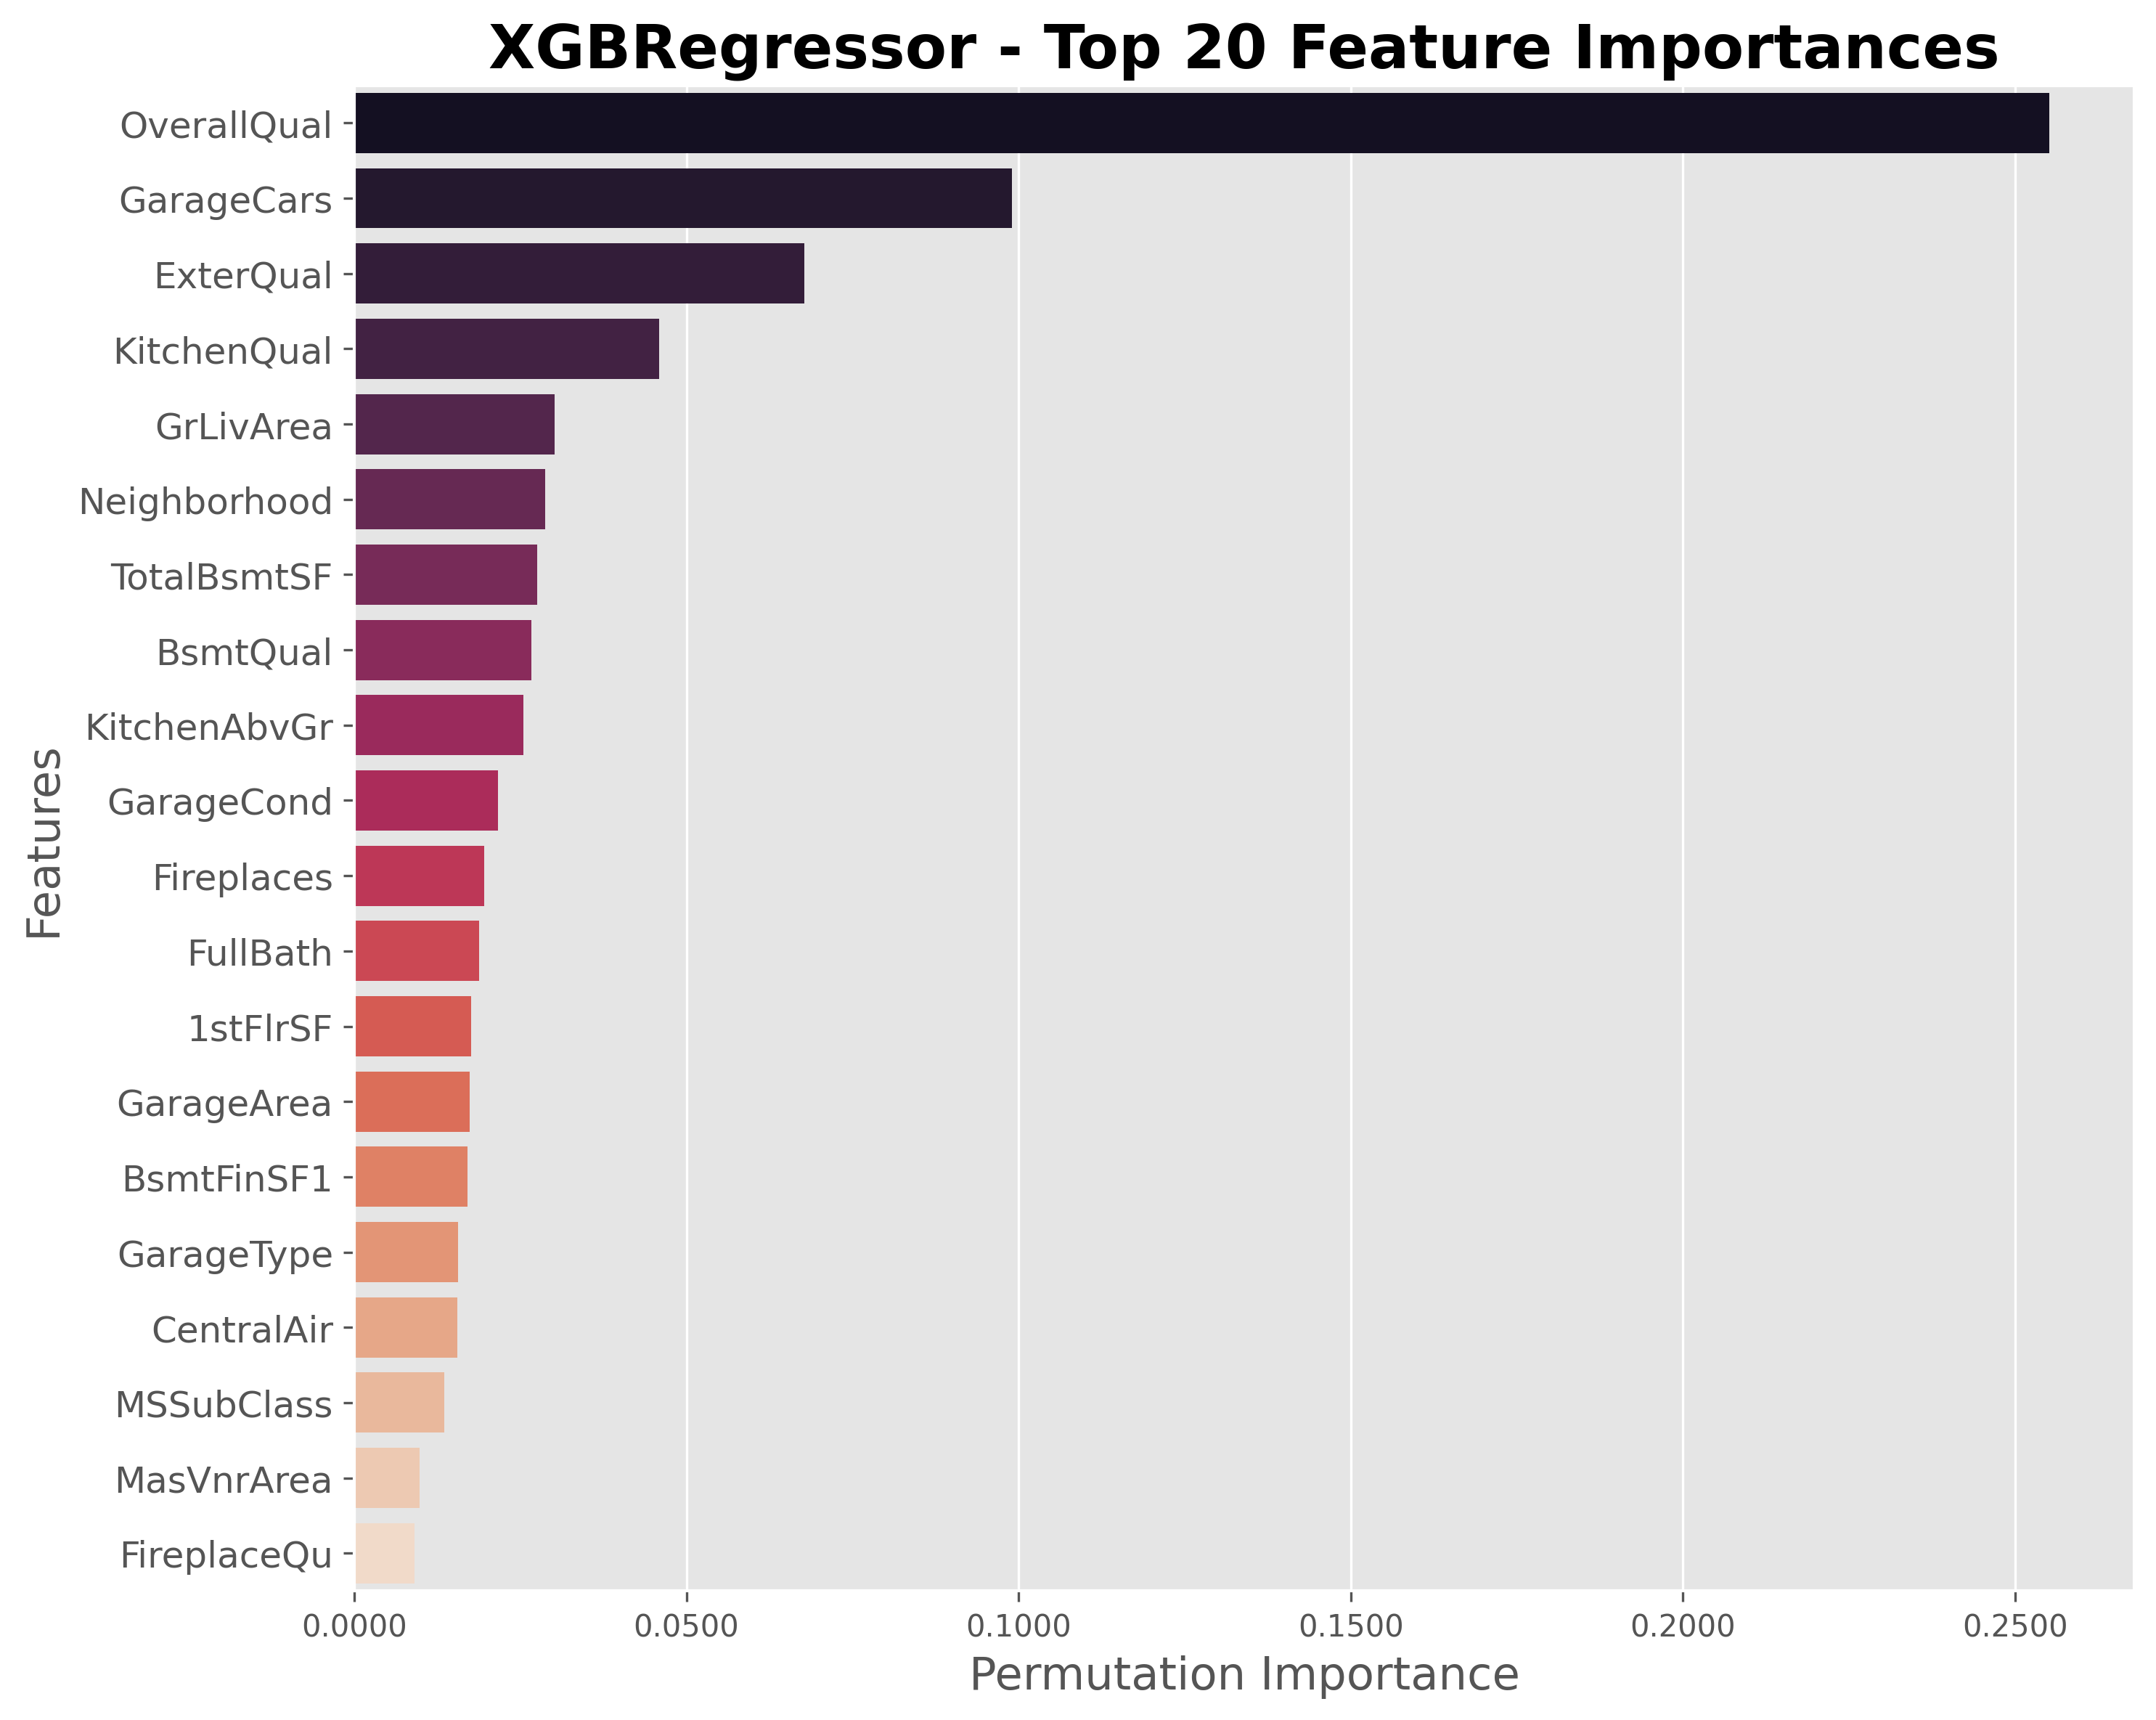

,Feature,Importance
0,OverallQual,0.2552
1,GarageCars,0.0990
2,ExterQual,0.0677
3,KitchenQual,0.0459
4,GrLivArea,0.0301
5,Neighborhood,0.0287
6,TotalBsmtSF,0.0275
7,BsmtQual,0.0267
8,KitchenAbvGr,0.0254
9,GarageCond,0.0216


In [30]:
#XGBoost Feature Importances & SHAP values
Plot_Feature_Importances_Only(random_search_xgbm, X2)

In [14]:
#Base LightGBM Model
lgbm = LGBMRegressor(random_state=2, verbose=1, n_jobs=-1)
lgbm.fit(X2, Y)
#Results Dataframe
lgbm_cv_scores = cross_val_score(lgbm, X2, Y, cv=5, scoring='r2')
lgbm_mean_cv_score = np.mean(lgbm_cv_scores)
lgbm_base_results_df = pd.DataFrame({
    'Model_Category': ['Tree_Based'],
    'Model_Scaling': ['None'],
	'OneHot': ['Native'],
    'Tuning': ['Base'],
    'Model': ['LightGBM'],
    'Mean_R²': [lgbm_mean_cv_score],
    **{f'Fold_{i+1}_R²': [lgbm_cv_scores[i]] for i in range(5)}
})

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001860 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3876
[LightGBM] [Info] Number of data points in the train set: 2579, number of used features: 75
[LightGBM] [Info] Start training from score 178053.442420
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001535 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3787
[LightGBM] [Info] Number of data points in the train set: 2063, number of used features: 75
[LightGBM] [Info] Start training from score 177061.364033
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001648 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3799
[LightGBM] [Info] Number of data points in the train set: 2063, number of used features: 75
[LightGBM] [Info] St

In [32]:
print('LightGBM Base Model Score:', float(cross_val_score(lgbm, X2, Y).mean()))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001993 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3787
[LightGBM] [Info] Number of data points in the train set: 2063, number of used features: 75
[LightGBM] [Info] Start training from score 177061.364033
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002147 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3799
[LightGBM] [Info] Number of data points in the train set: 2063, number of used features: 75
[LightGBM] [Info] Start training from score 177182.857974
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002011 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3791
[LightGBM] [Info] Number of data points in the train set: 2063, number of used features: 75
[LightGBM] [Info] St

In [23]:
#Initial LightGBM RandomizedSearchCV for faster estimates
lgbm_param = {
    'learning_rate': [0.04, 0.05, 0.0625],
    'subsample': [1.0],
    'colsample_bytree': [0.3125, 0.34375, 0.375],
    'min_child_samples': [15, 16, 17],
    'num_leaves': [22, 23],
    'max_depth': [34, 35, 36],
    'n_estimators': range(164, 170),
    'reg_lambda': [0.84375, .875, 0.90625],
    'reg_alpha': [0.05, 0.053125, 0.05625]
}
random_search_lgbm = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=lgbm_param,
    n_iter=20,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    random_state=2,
    verbose=1
)
random_search_lgbm.fit(X2, Y)
print('Best parameters:', random_search_lgbm.best_params_)
print(f'Best CV Score: {random_search_lgbm.best_score_:.4f}')

#Results Dataframe
lgbm_cv_results_df = pd.DataFrame(random_search_lgbm.cv_results_)
lgbm_best_row = lgbm_cv_results_df.loc[lgbm_cv_results_df['rank_test_score'] == 1].iloc[0]
lgbm_fold_scores = [lgbm_best_row[f'split{i}_test_score'] for i in range(5)]
lgbm_tuned_results_df = pd.DataFrame({
    'Model_Category': ['Tree_Based'],
    'Model_Scaling': ['None'],
    'OneHot': ['Native'],
    'Tuning': ['Tuned'],
    'Model': ['LightGBM'],
    'Mean_R²': [lgbm_best_row['mean_test_score']],
    **{f'Fold_{i+1}_R²': [lgbm_fold_scores[i]] for i in range(5)}
})

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001910 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3876
[LightGBM] [Info] Number of data points in the train set: 2579, number of used features: 75
[LightGBM] [Info] Start training from score 178053.442420
Best parameters: {'subsample': 1.0, 'reg_lambda': 0.875, 'reg_alpha': 0.05, 'num_leaves': 23, 'n_estimators': 169, 'min_child_samples': 16, 'max_depth': 35, 'learning_rate': 0.05, 'colsample_bytree': 0.375}
Best CV Score: 0.9261


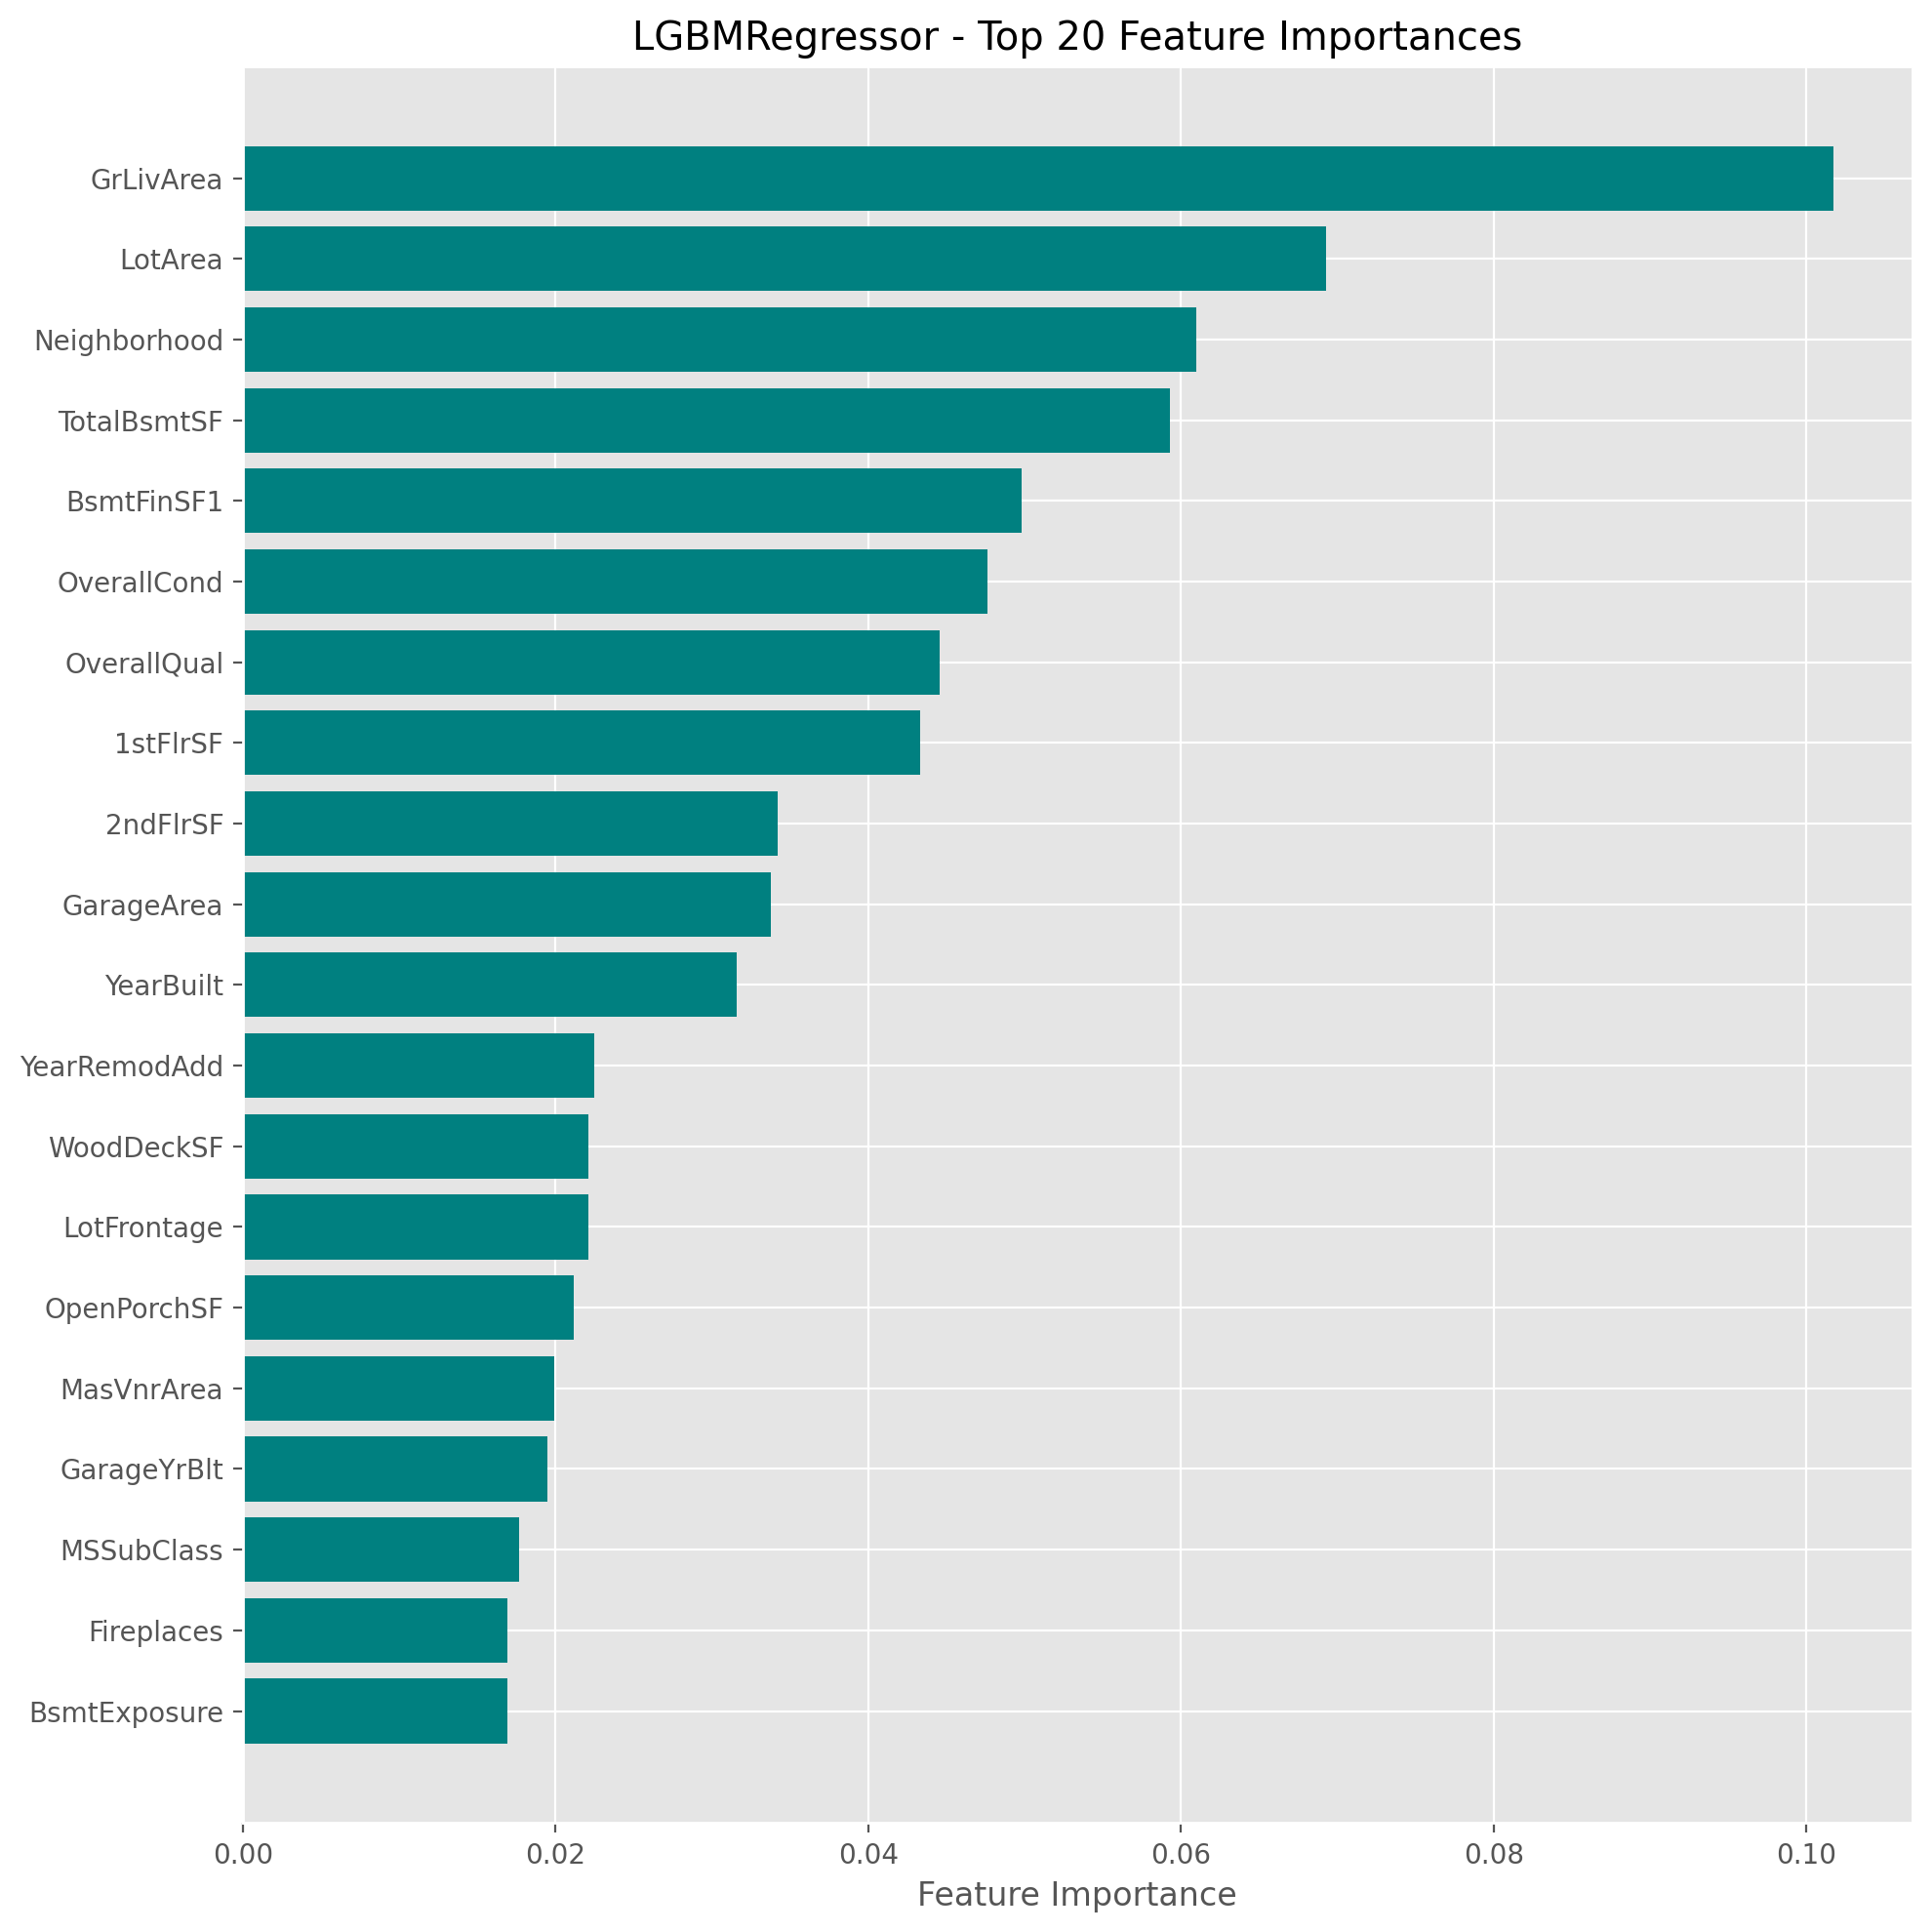

,Feature,Importance
0,GrLivArea,0.1017
1,LotArea,0.0693
2,Neighborhood,0.0610
3,TotalBsmtSF,0.0593
4,BsmtFinSF1,0.0498
5,OverallCond,0.0476
6,OverallQual,0.0446
7,1stFlrSF,0.0433
8,2ndFlrSF,0.0342
9,GarageArea,0.0338


In [89]:
#LightGBM Feature Importances & SHAP values
Plot_Feature_Importances_Only(random_search_lgbm, X2)

In [17]:
lgbm_GOSS = LGBMRegressor(random_state=2, verbose=1, n_jobs=-1, boosting_type='goss')
lgbm_GOSS.fit(X2, Y)

#Results Dataframe
lgbm_GOSS_cv_scores = cross_val_score(lgbm_GOSS, X2, Y, cv=5, scoring='r2')
lgbm_GOSS_mean_cv_score = np.mean(lgbm_GOSS_cv_scores)
lgbm_GOSS_base_results_df = pd.DataFrame({
    'Model_Category': ['Tree_Based'],
    'Model_Scaling': ['None'],
	'OneHot': ['Native'],
    'Tuning': ['Base'],
    'Model': ['LightGBM_GOSS'],
    'Mean_R²': [lgbm_GOSS_mean_cv_score],
    **{f'Fold_{i+1}_R²': [lgbm_GOSS_cv_scores[i]] for i in range(5)}
})

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001501 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3876
[LightGBM] [Info] Number of data points in the train set: 2579, number of used features: 75
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 178053.442420
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

In [91]:
print('LightGBM GOSS Base Model Score:', float(cross_val_score(lgbm_GOSS, X2, Y).mean()))

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001469 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3787
[LightGBM] [Info] Number of data points in the train set: 2063, number of used features: 75
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 177061.364033
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

In [24]:
#Initial LightGBM GOSS RandomizedSearchCV for faster estimates
lgbm_GOSS_param = {
    'learning_rate': [0.04, 0.05, 0.0625],
    'subsample': [1.0],
    'colsample_bytree': [0.3125, 0.34375, 0.375],
    'min_child_samples': [15, 16, 17],
    'num_leaves': [22, 23],
    'max_depth': [34, 35, 36],
    'n_estimators': range(164, 170),
    'reg_lambda': [0.84375, .875, 0.90625],
    'reg_alpha': [0.05, 0.053125, 0.05625]
}
random_search_lgbm_GOSS = RandomizedSearchCV(
    estimator=lgbm_GOSS,
    param_distributions=lgbm_GOSS_param,
    n_iter=20,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    random_state=2,
    verbose=1
)
random_search_lgbm_GOSS.fit(X2, Y)
print('Best parameters:', random_search_lgbm_GOSS.best_params_)
print(f'Best CV Score: {random_search_lgbm_GOSS.best_score_:.4f}')

#Results Dataframe
lgbm_GOSS_cv_results_df = pd.DataFrame(random_search_lgbm_GOSS.cv_results_)
lgbm_GOSS_best_row = lgbm_GOSS_cv_results_df.loc[lgbm_GOSS_cv_results_df['rank_test_score'] == 1].iloc[0]
lgbm_GOSS_fold_scores = [lgbm_GOSS_best_row[f'split{i}_test_score'] for i in range(5)]
lgbm_GOSS_tuned_results_df = pd.DataFrame({
    'Model_Category': ['Tree_Based'],
    'Model_Scaling': ['None'],
    'OneHot': ['Native'],
    'Tuning': ['Tuned'],
    'Model': ['LightGBM_GOSS'],
    'Mean_R²': [lgbm_GOSS_best_row['mean_test_score']],
    **{f'Fold_{i+1}_R²': [lgbm_GOSS_fold_scores[i]] for i in range(5)}
})

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001957 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3876
[LightGBM] [Info] Number of data points in the train set: 2579, number of used features: 75
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 178053.442420
Best parameters: {'subsample': 1.0, 'reg_lambda': 0.84375, 'reg_alpha': 0.05, 'num_leaves': 22, 'n_estimators': 164, 'min_child_samples':

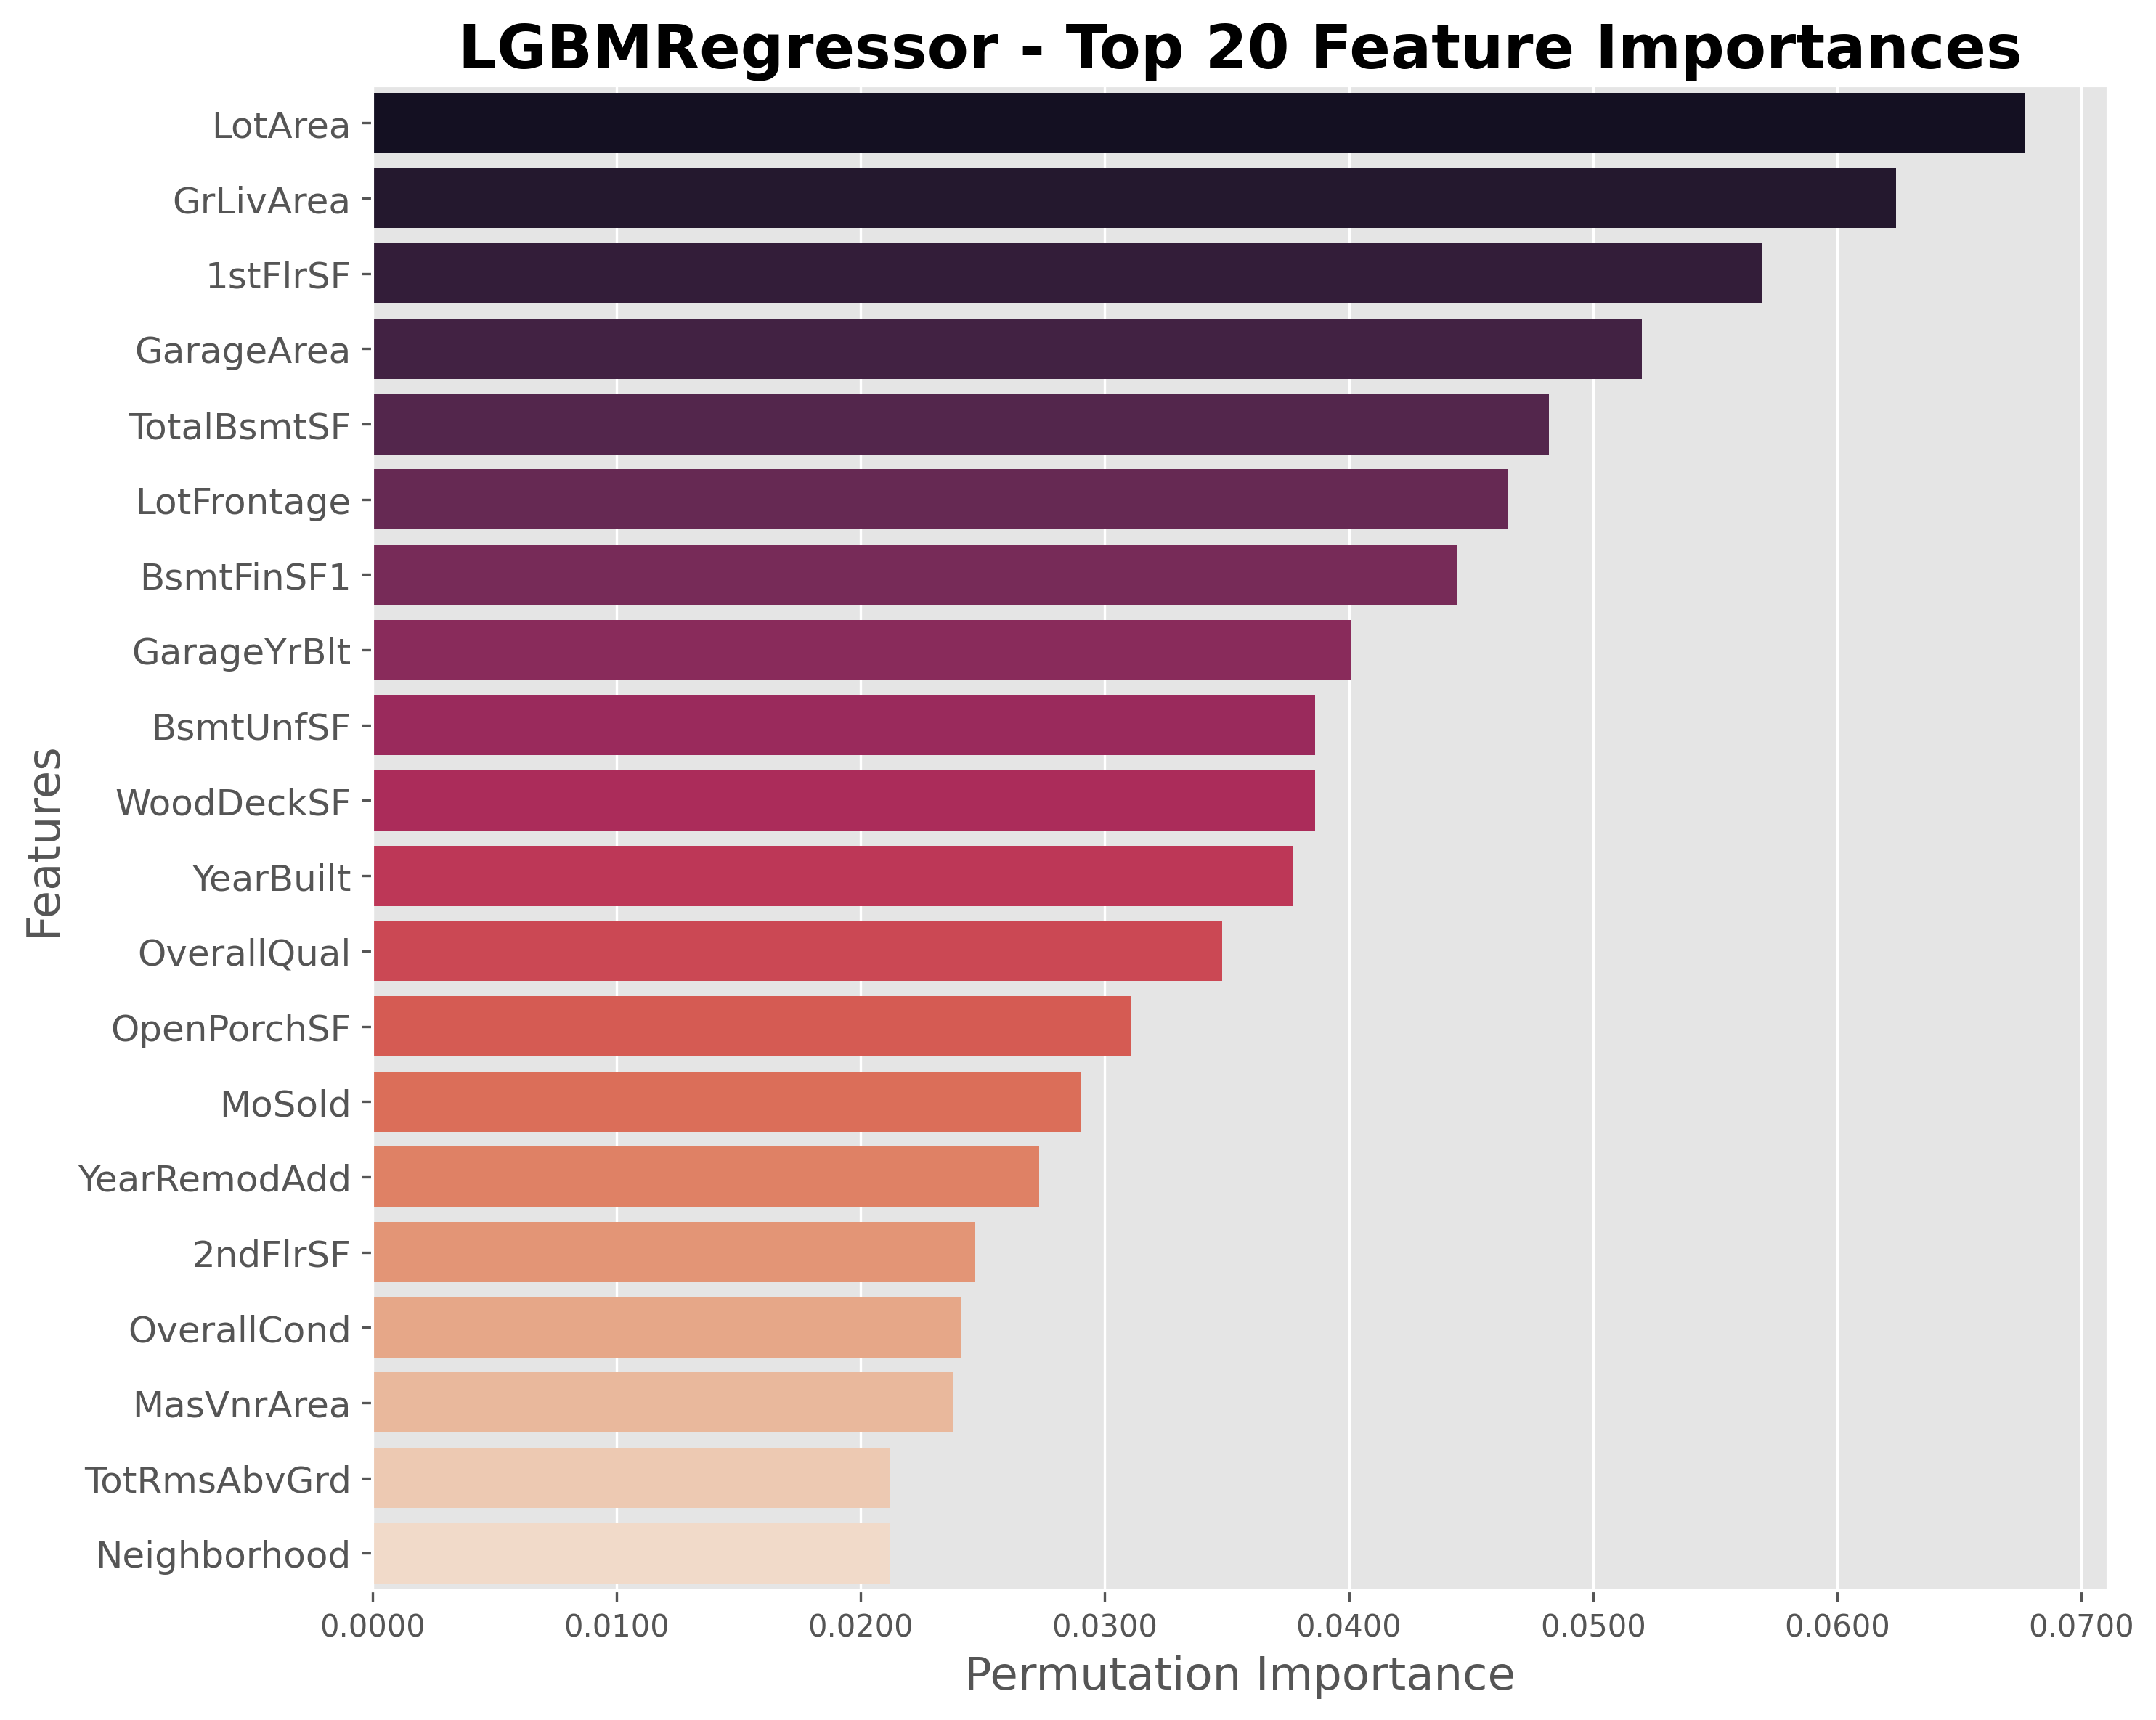

,Feature,Importance
0,LotArea,0.0677
1,GrLivArea,0.0624
2,1stFlrSF,0.0569
3,GarageArea,0.0520
4,TotalBsmtSF,0.0482
5,LotFrontage,0.0465
6,BsmtFinSF1,0.0444
7,GarageYrBlt,0.0401
8,BsmtUnfSF,0.0386
9,WoodDeckSF,0.0386


In [41]:
#LightGBM GOSS Feature Importances & SHAP values
Plot_Feature_Importances_Only(random_search_lgbm_GOSS, X2)

In [8]:
cat_boost = CatBoostRegressor(cat_features=[col for col in Ames_Columns_Nominal.columns], random_state=2, verbose=0, thread_count=-1)
cat_boost.fit(X2, Y)

#Results Dataframe
cat_cv_scores = cross_val_score(cat_boost, X2, Y, cv=5, scoring='r2')
cat_mean_cv_score = np.mean(cat_cv_scores)
cat_base_results_df = pd.DataFrame({
    'Model_Category': ['Tree_Based'],
    'Model_Scaling': ['None'],
	'OneHot': ['Native'],
    'Tuning': ['Base'],
    'Model': ['CatBoost'],
    'Mean_R²': [cat_mean_cv_score],
    **{f'Fold_{i+1}_R²': [cat_cv_scores[i]] for i in range(5)}
})

In [96]:
print('CatBoost Base Model Score:', float(cross_val_score(cat_boost, X2, Y).mean()))

CatBoost Base Model Score: 0.9302130804246369


In [26]:
#Initial CatBoost RandomizedSearchCV for faster estimates
cat_boost_param = {
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.1, 0.4, 0.7, 1.0],
    'colsample_bylevel': [0.1, 0.4, 0.7, 1.0],
    'min_data_in_leaf': [10, 20, 30],
    'depth': [4, 6, 8, 10],
    'iterations': range(150, 250),
    'l2_leaf_reg': [0.0, 0.1, 0.5, 1.0]
}
random_search_cat = RandomizedSearchCV(
    estimator=cat_boost,
    param_distributions=cat_boost_param,
    n_iter=20,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    random_state=2,
    verbose=1
)
random_search_cat.fit(X2, Y)
print('Best parameters:', random_search_cat.best_params_)
print(f'Best CV Score: {random_search_cat.best_score_:.4f}')

#Results Dataframe
cat_cv_results_df = pd.DataFrame(random_search_cat.cv_results_)
cat_best_row = cat_cv_results_df.loc[cat_cv_results_df['rank_test_score'] == 1].iloc[0]
cat_fold_scores = [cat_best_row[f'split{i}_test_score'] for i in range(5)]
cat_tuned_results_df = pd.DataFrame({
    'Model_Category': ['Tree_Based'],
    'Model_Scaling': ['None'],
    'OneHot': ['Native'],
    'Tuning': ['Tuned'],
    'Model': ['CatBoost'],
    'Mean_R²': [cat_best_row['mean_test_score']],
    **{f'Fold_{i+1}_R²': [cat_fold_scores[i]] for i in range(5)}
})

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters: {'subsample': 1.0, 'min_data_in_leaf': 10, 'learning_rate': 0.05, 'l2_leaf_reg': 0.0, 'iterations': 237, 'depth': 6, 'colsample_bylevel': 0.7}
Best CV Score: 0.9229


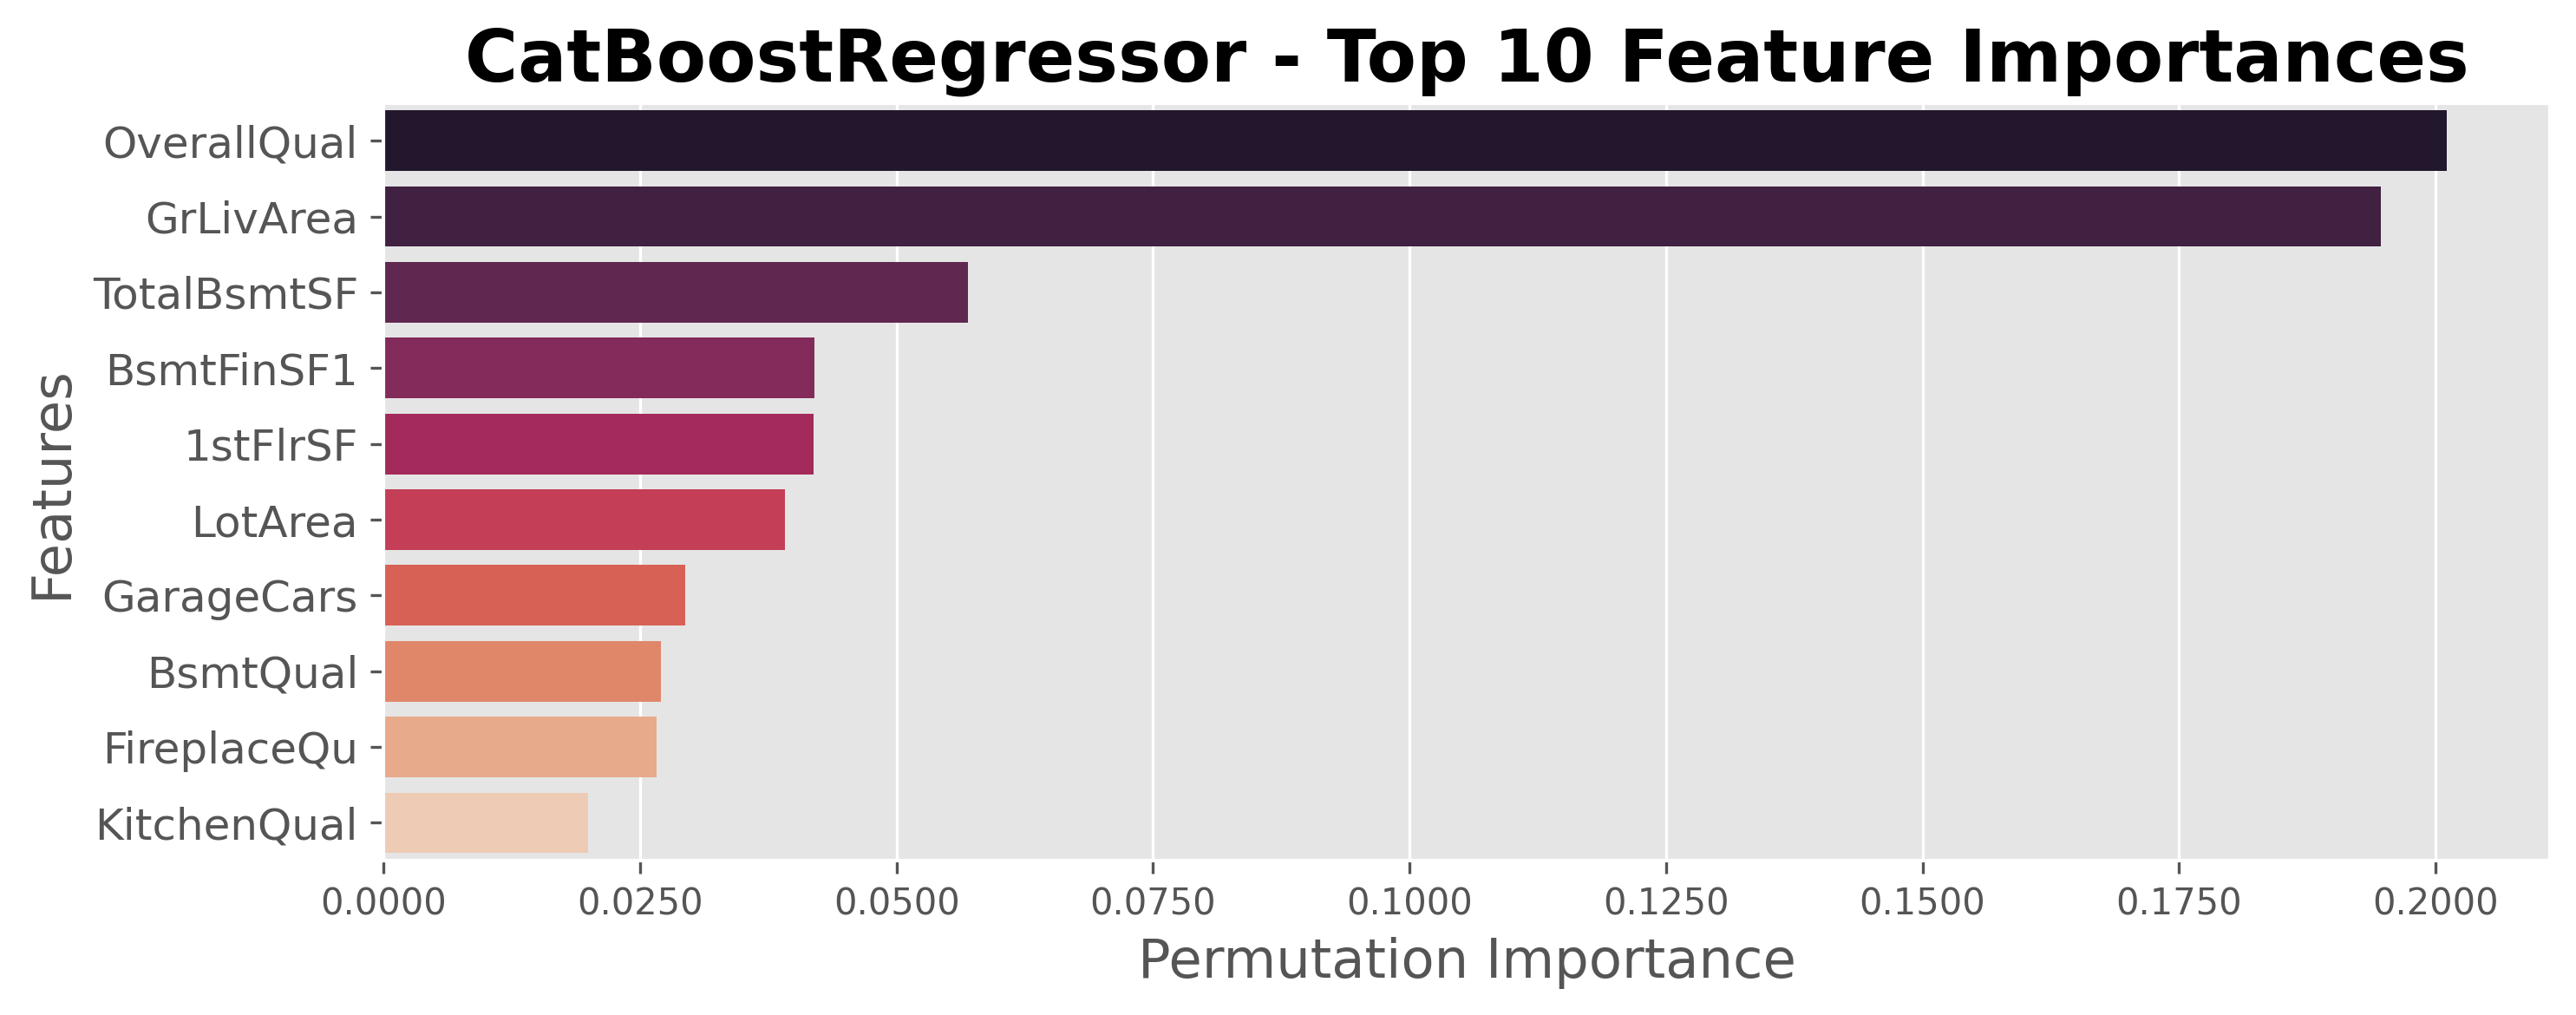

,Feature,Importance
0,OverallQual,0.2011
1,GrLivArea,0.1947
2,TotalBsmtSF,0.0570
3,BsmtFinSF1,0.0420
4,1stFlrSF,0.0419
5,LotArea,0.0391
6,GarageCars,0.0294
7,BsmtQual,0.0270
8,FireplaceQu,0.0266
9,KitchenQual,0.0199


In [9]:
#CatBoost Feature Importances & SHAP values
Plot_Feature_Importances_Only(cat_boost, X2)

In [30]:
#Concatenate all Results
Tree_Results_NativeOneHot_df = pd.concat(
    [hgbm_base_results_df,
    hgbm_tuned_results_df,
    xgbm_base_results_df,
    xgbm_tuned_results_df,
    lgbm_base_results_df,
    lgbm_tuned_results_df,
    lgbm_GOSS_base_results_df,
    lgbm_GOSS_tuned_results_df,
    cat_base_results_df,
    cat_tuned_results_df],
    axis=0,
    ignore_index=True
)
#Better Score column (Base vs Tuned)
Tree_Results_NativeOneHot_df['Model_Clean'] = Tree_Results_NativeOneHot_df['Model'].str.replace('_Base|_Tuned', '', regex=True)
Tree_Results_NativeOneHot_df['Better_Score'] = False
for model_name, group in Tree_Results_NativeOneHot_df.groupby('Model_Clean'):
    best_idx = group['Mean_R²'].idxmax()
    Tree_Results_NativeOneHot_df.loc[best_idx, 'Better_Score'] = True
Tree_Results_NativeOneHot_df.drop(columns=['Model_Clean'], inplace=True)

pd.set_option('display.float_format', lambda x: f'{x:.4f}')
Tree_Results_NativeOneHot_df

,Model_Category,Model_Scaling,OneHot,Tuning,Model,Mean_R²,Fold_1_R²,Fold_2_R²,Fold_3_R²,Fold_4_R²,Fold_5_R²,Better_Score
0,Tree_Based,None,Native,Base,HistGradientBoosting,0.9170,0.8629,0.9230,0.9339,0.9365,0.9288,False
1,Tree_Based,None,Native,Tuned,HistGradientBoosting,0.9258,0.8747,0.9287,0.9411,0.9446,0.9399,True
2,Tree_Based,None,Native,Base,XGBoost,0.9031,0.8494,0.9013,0.9156,0.9268,0.9224,False
3,Tree_Based,None,Native,Tuned,XGBoost,0.9260,0.8703,0.9408,0.9389,0.9447,0.9354,True
4,Tree_Based,None,Native,Base,LightGBM,0.9167,0.8603,0.9140,0.9362,0.9401,0.9330,False
5,Tree_Based,None,Native,Tuned,LightGBM,0.9261,0.8760,0.9218,0.9427,0.9450,0.9448,True
6,Tree_Based,None,Native,Base,LightGBM_GOSS,0.9148,0.8705,0.9088,0.9346,0.9327,0.9275,False
7,Tree_Based,None,Native,Tuned,LightGBM_GOSS,0.9226,0.8820,0.9193,0.9367,0.9343,0.9408,True
8,Tree_Based,None,Native,Base,CatBoost,0.9302,0.8824,0.9292,0.9518,0.9402,0.9474,True
9,Tree_Based,None,Native,Tuned,CatBoost,0.9229,0.8798,0.9196,0.9409,0.9355,0.9389,False


In [31]:
#Export Results
Tree_Results_NativeOneHot_df.to_csv('Tree_Results_NativeOneHot.csv', index=False)